In [1]:
# graph neural network 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv

In [2]:
print(len(np.load('cell_positions_for_training.npy')))


10000


TODO:

Get data from the actual system of interest

PINN!!!

Encoding?

Physics Informed Symbolic(?) Embedding/Latent(-something) Internally-recurrent Parsimonious Graph Neural Cellular Automata

In [33]:
class CustomGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(CustomGNN, self).__init__()
        # convolutional layer
        self.layer1 = GraphConv(input_dims, hidden_dims)

        # Linear layer
        self.layer2 = Linear(hidden_dims, hidden_dims)

        self.layer3 = Linear(hidden_dims, output_dims)

    def forward(self, feature_data, edge_info, edge_weights):
        # First GCN layer
        x = self.layer1(feature_data, edge_info, edge_weights)
        x = F.relu(x)
        
        # Second GCN layer
        x = self.layer2(x, )
        x = F.relu(x)

        x = self.layer3(x, )
        # x = torch.tanh(x)
        
        return x
    
    

class Enviroment():
    def __init__(self):
        # load the data

        self.positions = np.load('data/positions.npy')

        self.ys = []       
        self.y_test = [] 
        for i in range(4):
            for name in ("BMP", "FGF"):
                d = np.array([np.load(f'data/quarter_{i}_{name}.csv_BMP_levels.npy'), np.load(f'data/quarter_{i}_{name}.csv_FGF_levels.npy')])
                self.ys.append(torch.tensor(d.T, dtype=torch.float32))

            self.y_test.append(np.array([np.load(f'data/quarter_{i}_both.csv_BMP_levels.npy'), np.load(f'data/quarter_{i}_both.csv_FGF_levels.npy')]))
        

        self.model = None
        self.optimizer = None

        self.early_stop_count = 0

        self.edges = None
        self.edge_weights = None

        

    def loss_fn(self, out, target):
        return F.mse_loss(out, target)

    def get_edges(self, positions):
        # create a graph with 1000 nodes
        # create a KD tree for fast nearest neighbor search
        tree = KDTree(positions)
        dists, indices = tree.query(positions, k=10)

        indices[dists > 4.5] = -1

        # create adjacency matrix
        adj_matrix = np.zeros((100, 100))
        for i in range(100):
            for ji, j in enumerate(indices[i]):
                if j == -1:
                    continue
                adj_matrix[i, j] = dists[i, ji]
                adj_matrix[j, i] = dists[i, ji]

        # create edge data
        edges = torch.tensor(np.array(np.where(adj_matrix > 0)), dtype=torch.long).t().contiguous().T
        edge_weights = torch.tensor(adj_matrix[adj_matrix > 0], dtype=torch.float32)

        return edges, edge_weights

    def set_model(self, model):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    def call_model(self, X):
        if self.edges is None or self.edge_weights is None:
            self.edges, self.edge_weights = self.get_edges(self.positions)

        return self.model(X, self.edges, self.edge_weights)

    def transformation(self, X, target):
        angle = np.random.rand()*2*np.pi
        X = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in X])
        target = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in target])
        
        # scale = 0.5 + 1.5*np.random.rand()
        # X = X*scale
        # target = target*scale
        
        return X, target
    
    # def test(self):
    #     self.model.eval()
    #     with torch.no_grad():
    #         avg_loss = torch.tensor(0.0)
    #         rnge = 
    #         for i in rnge:
    #             X = self.y_test[i]
    #             target = self.y_test[i] - X

    #             edges, edge_weights = env.get_edges(X)

    #             out = self.model(X, edges, edge_weights)

    #             loss = self.loss_fn(out, target)

    #             avg_loss += loss.item()

    #         avg_loss /= len(rnge)

    #         print('Test loss:', avg_loss.item())

    #     return avg_loss.item()
    
    def check_early_stop(self, avg_loss, test_loss):
        if test_loss < avg_loss:
            self.early_stop_count = 0
            return False

        if self.early_stop_count >= 3:
            return True
        
        self.early_stop_count += 1
        return False
        



    def train(self, epochs):
        assert self.model is not None, "Model is not initialized"

        # train the model
        self.model.train()
        for epoch in range(1,epochs+1):
            loss = torch.tensor(0.0)
            avg_loss = torch.tensor(0.0)
            print((epoch)%5 if (epoch)%5 !=0 else 5, end='\r')

            for yy in self.ys:
                n_steps = yy.shape[1] - 1
                for i in range(1,n_steps):
                    X = yy[:,i]
                    target = yy[:,i + 1]

                    # X, target = self.transformation(X, target)

                    self.optimizer.zero_grad()

                    out = self.call_model(X)

                    loss = self.loss_fn(out, target) 

                    loss.backward()
                    self.optimizer.step()
                    avg_loss += loss.item()
            
            avg_loss /= n_steps

            avg_loss = avg_loss.item()

            if epoch % 5 == 0:
                print(epoch)
                print(f"{epoch/epochs:.3} loss:", avg_loss)
                # test_loss = self.test()
                # if self.check_early_stop(avg_loss, test_loss):
                    # print('Early stoppping')
                    # break



# create a GNN model
model = CustomGNN(2, 8, 2)

# create a training enviroment
env = Enviroment()

env.set_model(model)

env.train(5000)

5
0.001 loss: 0.6616858243942261
10
0.002 loss: 0.43860870599746704
15
0.003 loss: 0.39238983392715454
20
0.004 loss: 0.3645697832107544
25
0.005 loss: 0.36720359325408936
30
0.006 loss: 0.34544089436531067
35
0.007 loss: 0.3387848734855652
40
0.008 loss: 0.3351508378982544
45
0.009 loss: 0.33305227756500244
50
0.01 loss: 0.3299669325351715
55
0.011 loss: 0.32685044407844543
60
0.012 loss: 0.3364538252353668


KeyboardInterrupt: 

(2, 1001, 100)


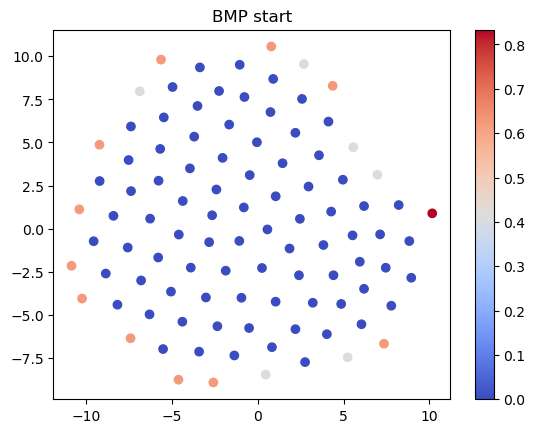

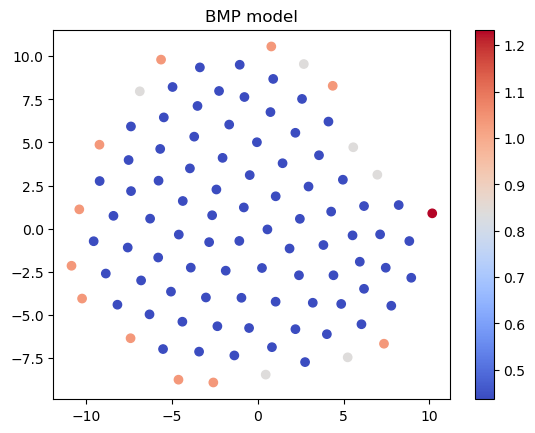

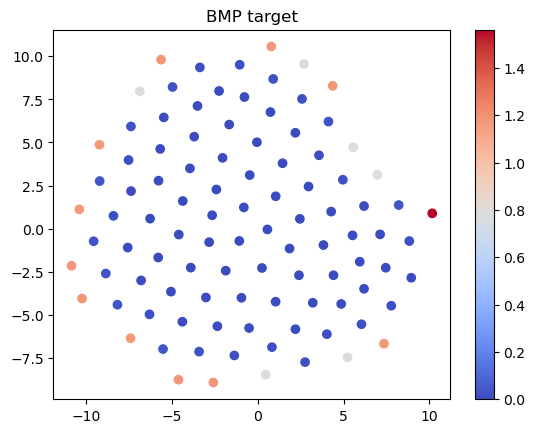

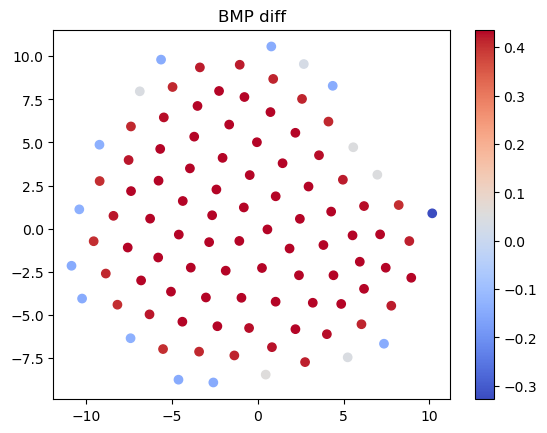

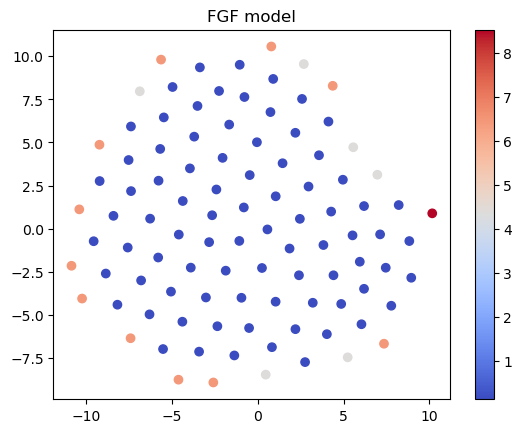

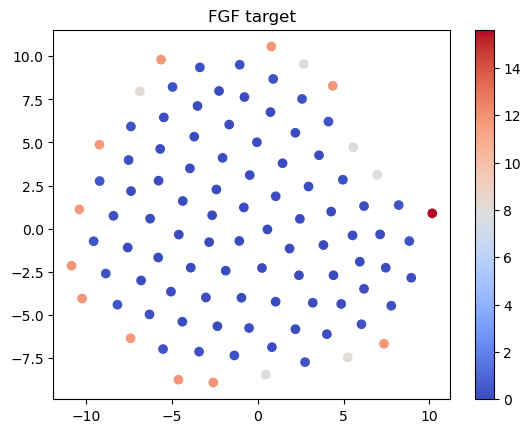

In [36]:
model.train(False)

y_val = np.array([np.load(f'data/quarter_3_both.csv_BMP_levels.npy'), np.load(f'data/quarter_3_both.csv_FGF_levels.npy')])
print(y_val.shape)
X = torch.tensor(y_val.T[:,1], dtype=torch.float32)
target = torch.tensor(y_val.T[:,2], dtype=torch.float32)

edges, edge_weights = env.get_edges(env.positions)

out = model(X, edges, edge_weights)

out = out.detach().numpy()


plt.scatter(env.positions[:,0], env.positions[:,1], c=X[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('BMP start')
plt.show()

plt.scatter(env.positions[:,0], env.positions[:,1], c=out[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('BMP model')
plt.show()


plt.scatter(env.positions[:,0], env.positions[:,1], c=target[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('BMP target')
plt.show()

# plot diff

plt.scatter(env.positions[:,0], env.positions[:,1], c=out[:,0] - target[:,0].detach().numpy(), cmap='coolwarm')
plt.colorbar()
plt.title('BMP diff')
plt.show()



plt.scatter(env.positions[:,0], env.positions[:,1], c=out[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('FGF model')
plt.show()


plt.scatter(env.positions[:,0], env.positions[:,1], c=target[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('FGF target')
plt.show()

In [41]:
# access the weights

for name, param in model.named_parameters():  
    if not "weight" in name:
        continue
    print(name, "\n",param.data, param.data.shape)

layer1.lin_rel.weight 
 tensor([[-0.4575, -0.3122],
        [-0.1776,  0.0177],
        [-1.5370, -0.7691],
        [ 0.4502, -0.0633],
        [-0.0622,  0.0018],
        [-0.4502, -0.4063],
        [-0.1715, -0.8031],
        [-0.4037, -0.6081]]) torch.Size([8, 2])
layer1.lin_root.weight 
 tensor([[ -0.8338,   0.5938],
        [  5.0136,   6.2314],
        [ -0.6142,  -1.6636],
        [  0.8565, -10.8365],
        [  0.6790,  -0.1669],
        [ -0.6515,   0.6477],
        [ -0.9794,  -0.4146],
        [  0.2739,   0.4696]]) torch.Size([8, 2])
layer2.weight 
 tensor([[-6.1876e-01, -1.7062e-01, -3.2356e-03, -3.0454e-02, -1.6061e-01,
          2.9476e-01, -3.4356e-01,  8.9857e-03],
        [-1.0554e-01, -2.3168e-02, -1.7915e-01, -3.7360e+00,  1.6371e-01,
          1.0383e-01, -6.1878e-01,  3.0504e-01],
        [-4.0434e-01, -3.5949e-01,  1.4629e+00, -1.3745e-01,  1.4719e-01,
          2.2210e-01,  6.3042e-02,  1.4844e-01],
        [-8.3662e-02, -2.1473e-01,  3.3740e-02, -6.1693e-02, -